#### Brian Ramirez

# Time Series Modeling

## Research Question

<p>Using time series modeling techniques, can the first two years of a company's revenue data be used to forecast the next quarter's revenue?</p>

Goals of the data analysis:
<ul>
    <li>Identify trends in the first two years of revenue data</li>
    <li>Use the insight to build a predictive model</li>
    <li>Use the model to forecast the next quarter's revenue</li>
</ul>

## Assumptions

<strong>Stationarity Data</strong><br>
<p>Stationary Data is a core assumption of a Time Series model. According to <em>Practical Time Series Analysis</em>, a Time Series analysis requires "that the internal structures of the series do not change over time" (Pal & Prakash, 2017). A lack of stationarity data would prevent the analysis from rendering a valid forecast.</p>

<strong>Auto-correlated Data</strong><br>
<p>Time Series is unique in that it assumes one data point is dependent on another. According to <em>Autocorrelation in Time Series Data</em>, Time Series analysis "often displays serial dependence" in which "the value of a datapoint at one time is statistically dependent on another datapoint in another time"(Dotis-Georgiou, 2019). The assumption is unique because many forms of analysis assume data is statistically independent.</p>

## Data Preparation

<strong>Import Packages and Libraries</strong>

In [3]:
import seaborn as sns

import pmdarima as pm
from pmdarima import auto_arima, arima

import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np
from numpy import cumsum

from scipy import signal
from scipy import stats

from datetime import datetime

from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

import warnings
warnings.filterwarnings('ignore')

<strong>Load Data and Create Data Frame using Pandas</strong><br>

In [2]:
df = pd.read_csv("/Medical_Data/medical_time_series.csv", index_col = 0, parse_dates = True)
print('Shape:', df.shape)

Shape: (731, 1)


<strong>Inspect the Data</strong>

In [3]:
df.head()

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888


In [4]:
df.tail()

,Revenue
Day,
727,15.722056
728,15.865822
729,15.708988
730,15.822867
731,16.069429


In [5]:
df.describe()

,Revenue
count,731.000000
mean,14.179608
std,6.959905
min,-4.423299
25%,11.121742
50%,15.951830
75%,19.293506
max,24.792249


<strong>Plot the Data</strong>

<AxesSubplot:xlabel='Day'>

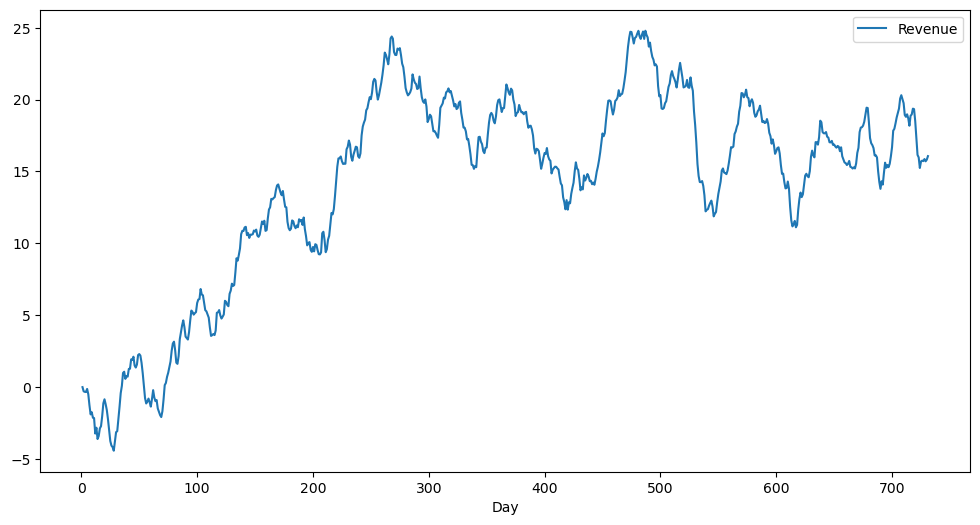

In [6]:
df.plot()

<strong>Convert Day to Date</strong><br>
Convert the day to a date to conform with Time Series Model.<br>
The date will begin at 01 January 2021 and include two full years day-by-day.

In [7]:
df.index = pd.to_datetime(df.index, unit = 'D', origin = '2020-12-31')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2021-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


,Revenue
Day,
2021-01-01,0.000000
2021-01-02,-0.292356
2021-01-03,-0.327772
2021-01-04,-0.339987
2021-01-05,-0.124888
...,...
2022-12-28,15.722056
2022-12-29,15.865822
2022-12-30,15.708988


<strong>Clean the Dataset</strong><br>
Clean the dataset by checking and treating null values, na values, duplicate values, or outliers.

In [8]:
# Check for null values

df.isnull().any()

Revenue    False
dtype: bool

In [9]:
# Check for NA values

df.isna().any()

Revenue    False
dtype: bool

In [10]:
# Check for duplicates

df.duplicated().any()

False

In [11]:
# Check for outliers

df['rev_z'] = stats.zscore(df['Revenue'])
rev_outlier_df = df.query('rev_z > 3 | rev_z < -3')
rev_outlier_sorted_df = rev_outlier_df.sort_values(['rev_z'], ascending = False)
df.drop(columns = ['rev_z'], inplace = True)
rev_outlier_sorted_df.count()

Revenue    0
rev_z      0
dtype: int64

<p>The data set is clean and free of any null values, na values, duplicate values, or outliers.<br>
Futher treatment is not necessary.</p>

## Visual Realization of the Time Series

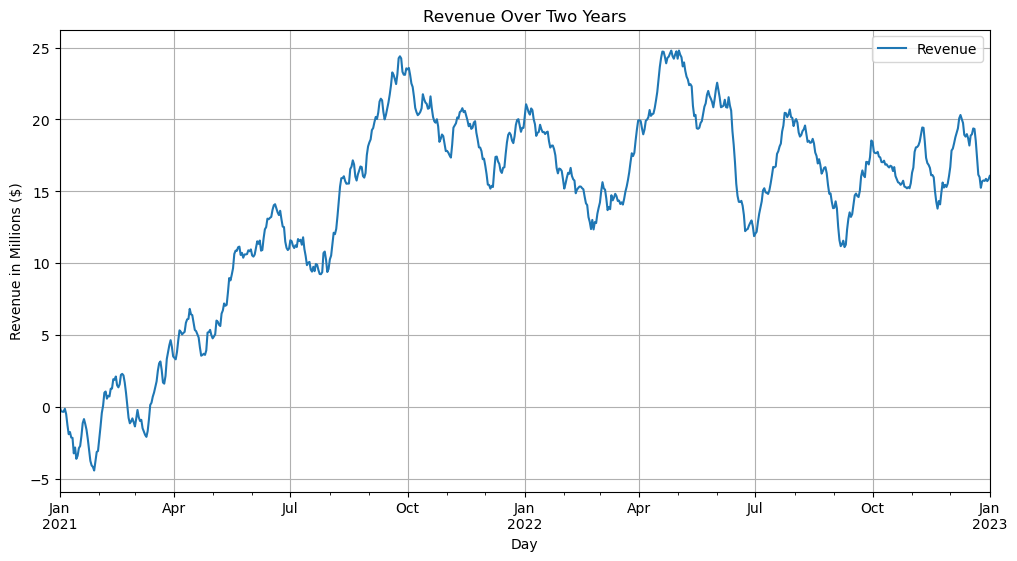

In [12]:
df.plot()
plt.title('Revenue Over Two Years')
plt.xlabel('Day')
plt.ylabel('Revenue in Millions ($)')
plt.grid(True)
plt.show()

## Time Step Formatting

<strong>Time Step</strong><br>
The time step formatting is daily.<br>

<strong>Measurement Gaps</strong><br>
No gaps found in the measurement.<br>

<strong>Sequence Length</strong><br>
The length of the sequence is 731 days.

## Stationarity of the Time Series
<strong>Initial Test for Stationarity</strong><br>

In [13]:
# Reference: D213 T1 Panopto Webinar

def init_test(dataset):
    ad_fuller_result = adfuller(dataset, autolag = 'AIC')
    data = ad_fuller_result[4]
    data = data.values()
    x = pd.DataFrame.from_dict(data)
    print(f'    ADF Statistic: {ad_fuller_result[0]}')
    print(f'          P-value: {ad_fuller_result[1]}')
    print(f'        Lag Count: {ad_fuller_result[2]}')
    print(f'Observation Count: {ad_fuller_result[3]}')
    print(f'  Critical Values: ')
    for key, value in ad_fuller_result[4].items():
        print(f'{key}, {"%.3f" % value}')
        
    if ad_fuller_result[1] <= 0.05 and x.iloc[0][0] > ad_fuller_result[0]:
        print("\nTime Series is stationary \nP-value: ", ad_fuller_result[1])
    else:
        print("\nTime Series is non-stationary \nP-value: ", ad_fuller_result[1])

init_test(df['Revenue'])

    ADF Statistic: -2.218319047608944
          P-value: 0.1996640061506439
        Lag Count: 1
Observation Count: 729
  Critical Values: 
1%, -3.439
5%, -2.866
10%, -2.569

Time Series is non-stationary 
P-value:  0.1996640061506439


<strong>Differencing Count</strong><br>
Count how many times the set must be differenced to make it stationary.

In [14]:
diff_count = np.diff(df['Revenue'], n = 1)
ad_fuller_result = adfuller(diff_count)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'      P-value: {ad_fuller_result[1]}')

ADF Statistic: -17.374772303557062
      P-value: 5.113206978840171e-30


<p>It appears the time series must be differenced one time to make it stationary.</p>

<strong>Make the Time Series Stationary</strong><br>
Difference the time series one time to make it stationary. 

In [15]:
df_stationary = df.diff().dropna()

<strong>Second Test for Stationarity</strong><br>
Conduct a second stationarity test.

In [16]:
init_test(df_stationary['Revenue'])

    ADF Statistic: -17.374772303557062
          P-value: 5.113206978840171e-30
        Lag Count: 0
Observation Count: 729
  Critical Values: 
1%, -3.439
5%, -2.866
10%, -2.569

Time Series is stationary 
P-value:  5.113206978840171e-30


<p>The time series appears to be stationary after being differenced one time.</p>

<strong>Inspect the Stationary Dataframe</strong>

In [17]:
df_stationary.head()

,Revenue
Day,
2021-01-02,-0.292356
2021-01-03,-0.035416
2021-01-04,-0.012215
2021-01-05,0.215100
2021-01-06,-0.366702


In [18]:
df_stationary.tail()

,Revenue
Day,
2022-12-28,-0.032693
2022-12-29,0.143766
2022-12-30,-0.156834
2022-12-31,0.113880
2023-01-01,0.246562


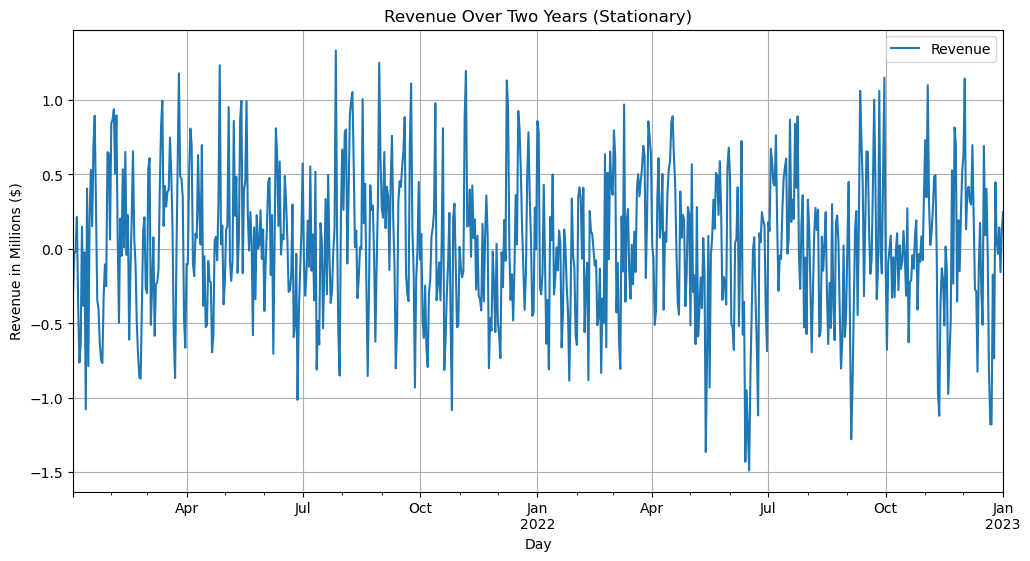

In [19]:
df_stationary.plot()
plt.title('Revenue Over Two Years (Stationary)')
plt.xlabel('Day')
plt.ylabel('Revenue in Millions ($)')
plt.grid(True)
plt.show()

<strong>Make a Copy of the Stationary Dataframe</strong>

In [20]:
clean_df = df_stationary.copy()

<strong>Create Training and Test Sets</strong><br>

<p>Split the data into two sets.<br>
The training set will contain 80% of the data.
The test set will contain 20% of the data.<br></p>

In [21]:
# Verify how many rows = 80%

len(df_stationary) * .8

584.0

In [22]:
train = df.iloc[:584]
test = df.iloc[584:]
print('  Train set columns:', train.columns)
print('Train set row count:', train.shape)
print('  Test set columns:', test.columns)
print('Test set row count:', test.shape)

  Train set columns: Index(['Revenue'], dtype='object')
Train set row count: (584, 1)
  Test set columns: Index(['Revenue'], dtype='object')
Test set row count: (147, 1)


<strong>Compute the Historical Mean</strong>

In [23]:
# Training set historical mean

hist_mean = np.mean(train['Revenue'])
print(hist_mean)

13.612029094722606


In [24]:
# Test set historical mean

test_set_mean = test.loc[:, 'pred_mean'] = hist_mean
print(test_set_mean)

13.612029094722606


## Steps Required for Time Series Analysis
The data preparation steps used are as follows:
<ol>
    <li>Load the data into a data frame.</li>
    <li>Inspect the data frame's shape.</li>
    <li>Inspect the data frame's head and tail values.</li>
    <li>Plot the data frame for visual inspection.</li>
    <li>Convert the days column index to dates for time-series analysis.</li>
    <li>Check and treat null or missing values.</li>
    <li>Check and treat duplicate values.</li>
    <li>Check and treat outliers.</li>
    <li>Plot the data again to visually inspect the clean time series.</li>
    <li>Test the time series for stationarity.</li>
    <li>Stationarity test failed.</li>
    <li>Make the time series stationary by differencing the data.</li>
    <li>Retest the time series for stationarity.</li>
    <li>Stationarity test passed.</li>
    <li>Split 80% of the data into a training set and 20% of the data into a test set.</li>     
</ol>
The code for each step is provided above.

## Clean Copies of the Data Sets

In [25]:
clean_df.to_csv('cleandata.csv')
train.to_csv('T1_train.csv')
test.to_csv('T1_test.csv')

## Model Identification and Analysis

In [26]:
decomp = seasonal_decompose(df['Revenue'], model = 'additive')
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

### Check for Seasonality
<p>Seasonality is detected in the data set as evidenced by the plot below.</p>

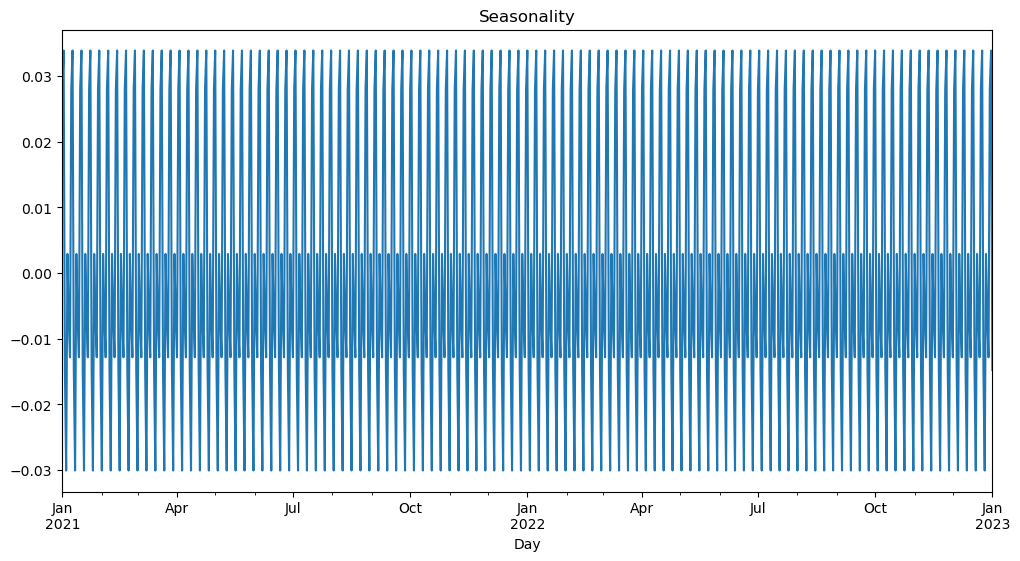

In [27]:
plt.title('Seasonality')
seasonal.plot()
plt.show()

### Check for Trends
<p>A positive trend is detected as evidenced by the plot below.</p>

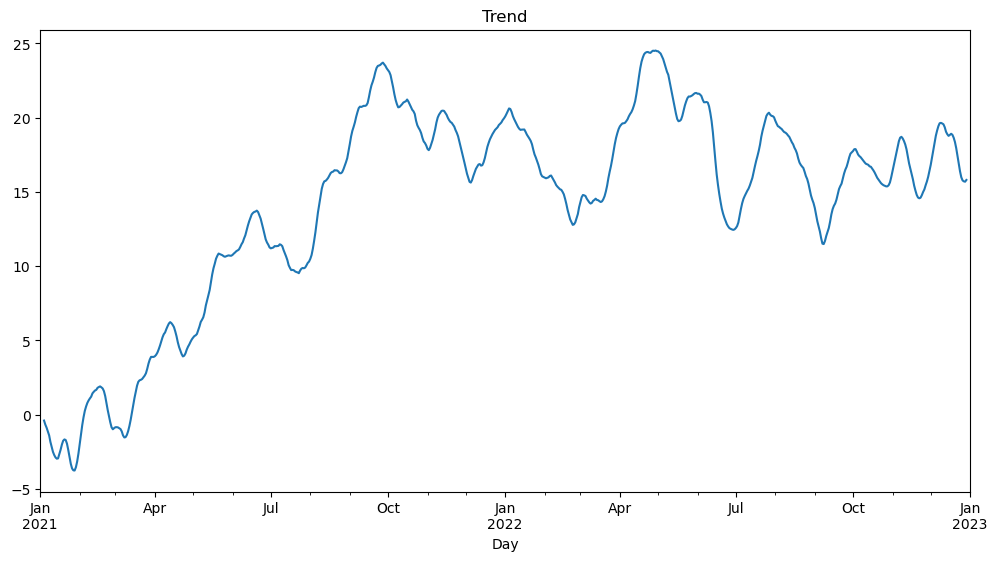

In [28]:
plt.title('Trend')
trend.plot()
plt.show()

###   Auto-correlation Function

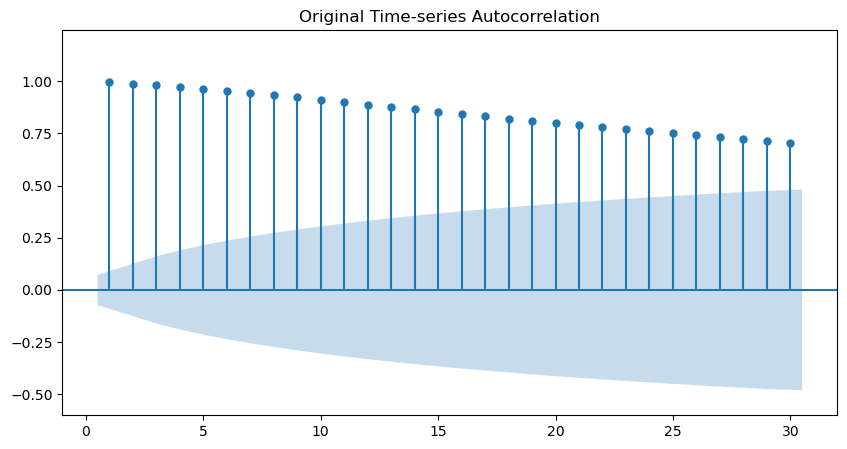

In [29]:
fig, ax = plt.subplots(1,1, figsize = (10, 5))
plot_acf(df.Revenue, lags = 30, auto_ylims = True, zero = False, ax = ax)
plt.title('Original Time-series Autocorrelation')
plt.show()

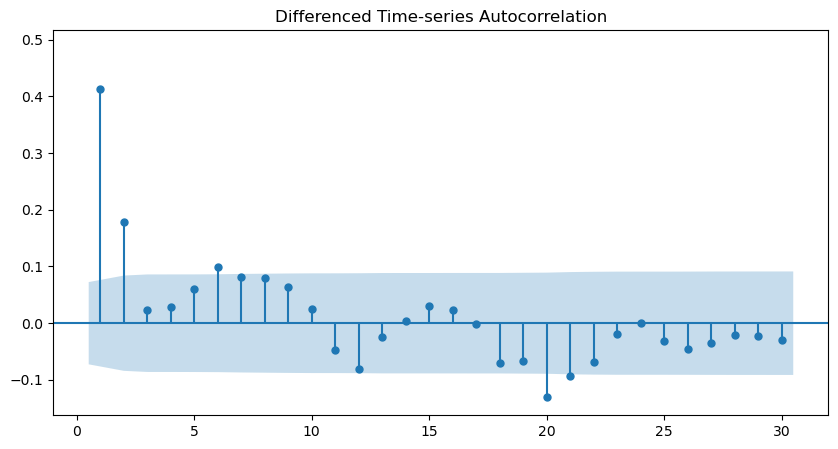

In [30]:
fig, ax = plt.subplots(1,1, figsize = (10, 5))
plot_acf(df_stationary, lags = 30, auto_ylims = True, zero = False, ax = ax)
plt.title('Differenced Time-series Autocorrelation')
plt.show()

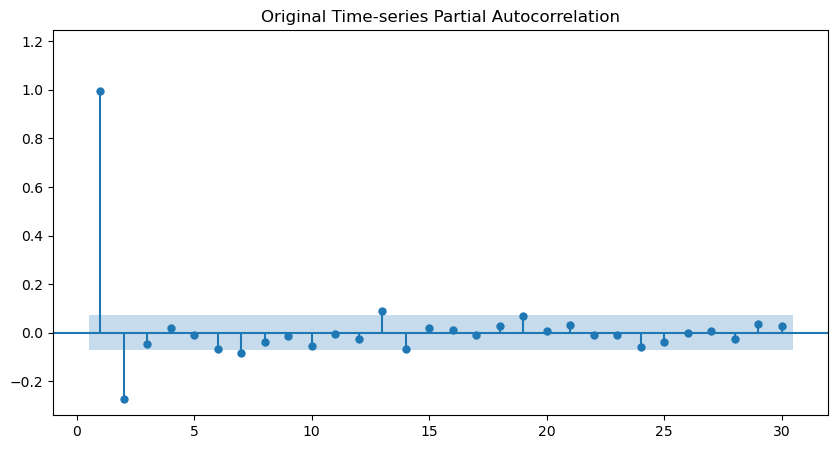

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plot_pacf(df['Revenue'], ax = ax, lags = 30, auto_ylims = True, zero = False)
plt.title('Original Time-series Partial Autocorrelation')
plt.show()

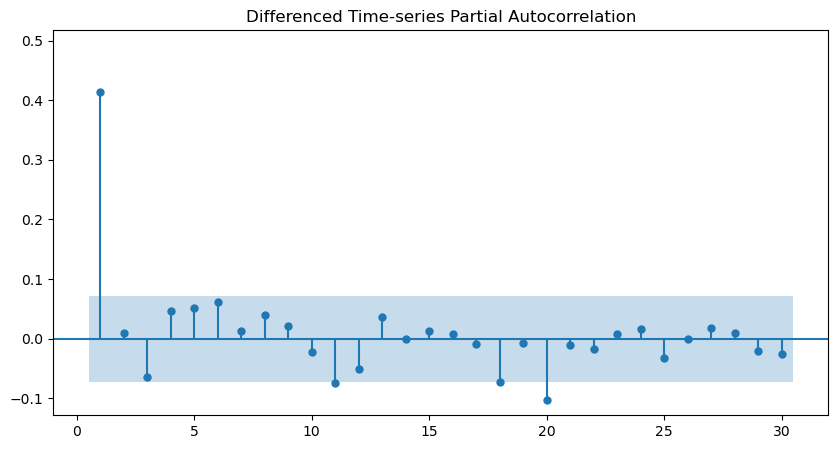

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plot_pacf(df_stationary, ax = ax, lags = 30, auto_ylims = True, zero = False)
plt.title('Differenced Time-series Partial Autocorrelation')
plt.show()

### Spectral Density

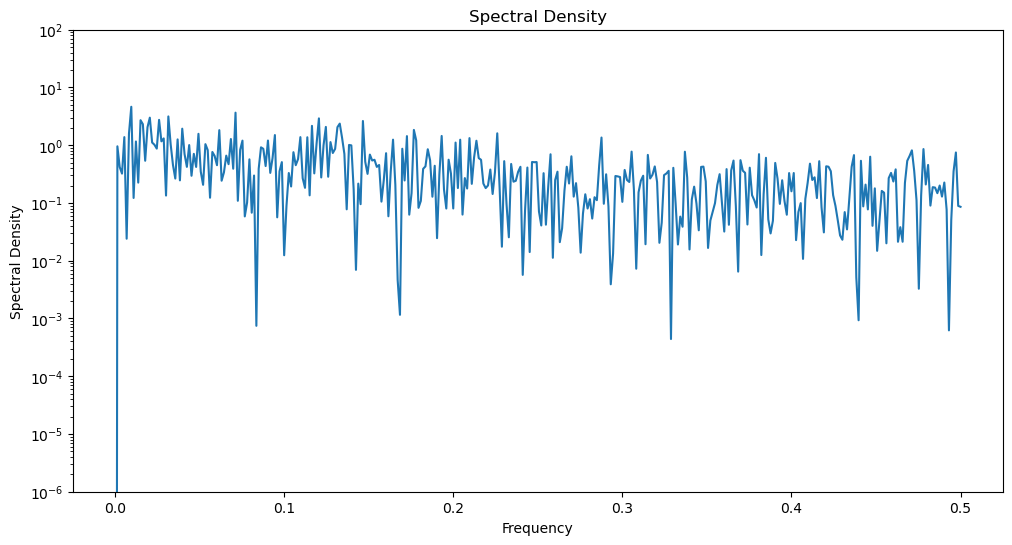

In [33]:
f, Pxx_den = signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim(1e-6, 1e2)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

### Decomposed Time Series

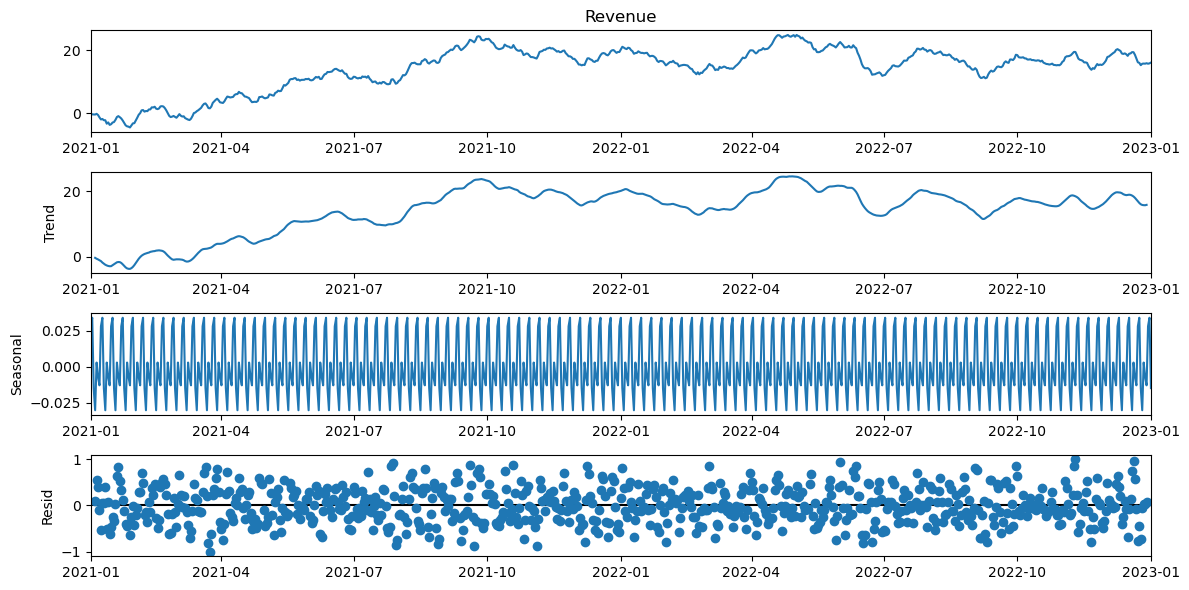

In [34]:
decomp.plot()
plt.show()

### Residuals

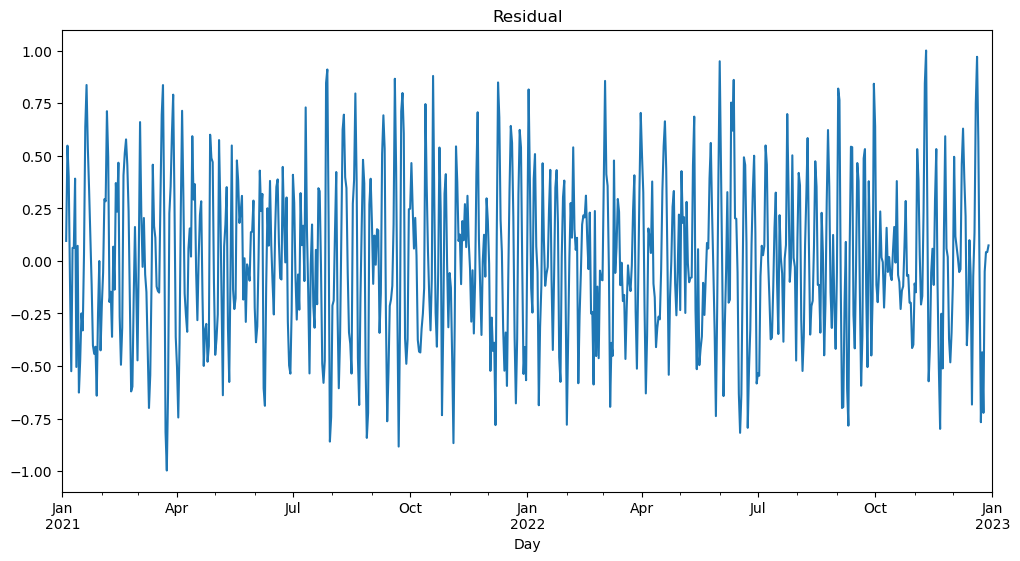

In [35]:
plt.title('Residual')
resid.plot()
plt.show()

## Autoregressive Integrated Moving Average (ARIMA) model

<p>An Auto-ARIMA will be performed to find the lowest model AIC Score. <br>
    The ideal model will take into account the observed trend and seasonality of the time series data.
</p>


In [36]:
auto_model = pm.auto_arima(train.Revenue, trace = True, supress_warnings = True, stepwise = True, seasonal = True)
auto_model.fit(train.Revenue)

for k, v in auto_model.get_params().items():
    if k == 'order' or k == 'seasonal_order':
        print(k, v)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=705.600, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=810.657, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=706.498, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=729.203, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=811.354, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=704.253, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=702.748, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=704.175, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=708.064, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=705.662, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=702.004, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=728.964, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=703.430, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=703.350, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=707.1

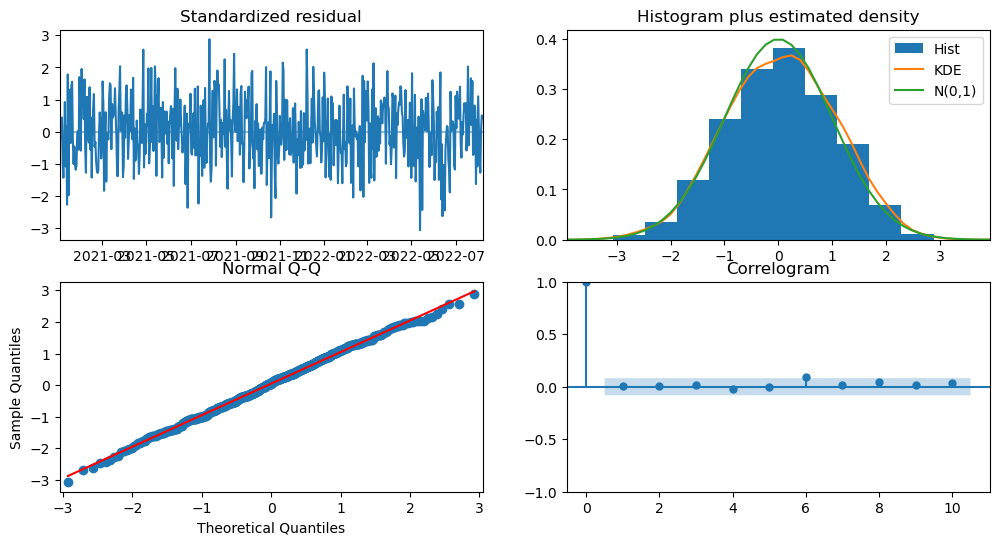

In [37]:
auto_model.plot_diagnostics();

<p>An initial model will be created with the order suggested by the Auto-ARIMA.</p>

In [38]:
init_model = SARIMAX(train['Revenue'], order =(auto_model.order))
init_model_fit = init_model.fit(disp = False)
print(init_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -348.002
Date:                Sun, 25 Jun 2023   AIC                            702.004
Time:                        22:15:31   BIC                            715.109
Sample:                    01-01-2021   HQIC                           707.112
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3930      0.040      9.771      0.000       0.314       0.472
ma.L2          0.2214      0.040      5.502      0.000       0.143       0.300
sigma2         0.1931      0.012     15.809      0.0

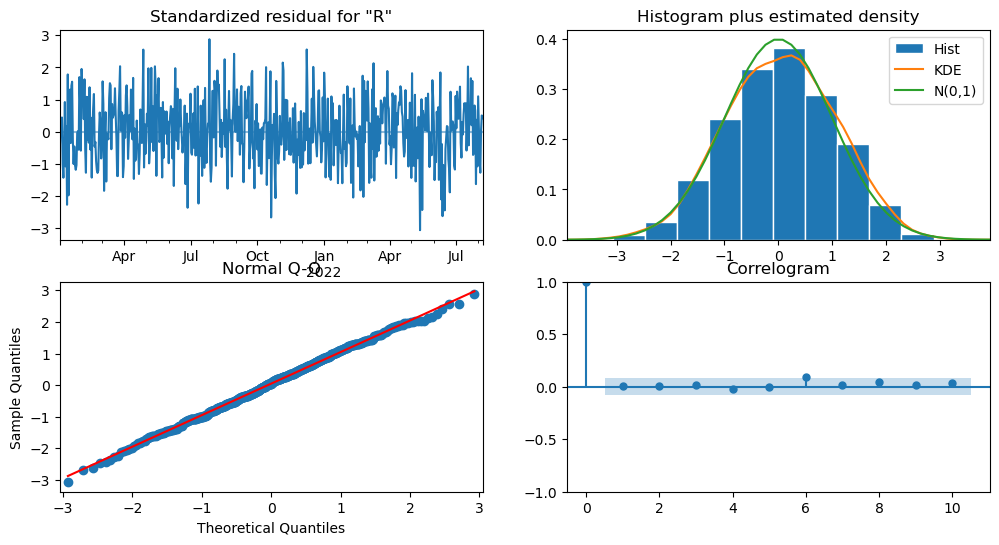

In [39]:
init_model_fit.plot_diagnostics();

### Forecast using the Derived ARIMA Model.

In [40]:
one_step_mod = SARIMAX(df['Revenue'], order = (auto_model.order), enforce_stationarity = False, enforce_invertibility = False)
one_step = one_step_mod.fit(disp = False)

start = len(train['Revenue'])
end = len(train['Revenue']) + len(test['Revenue']) - 1
one_step_pred = one_step.get_prediction(start = start, end = end)
one_step_pred_95 = one_step_pred.conf_int(.05)

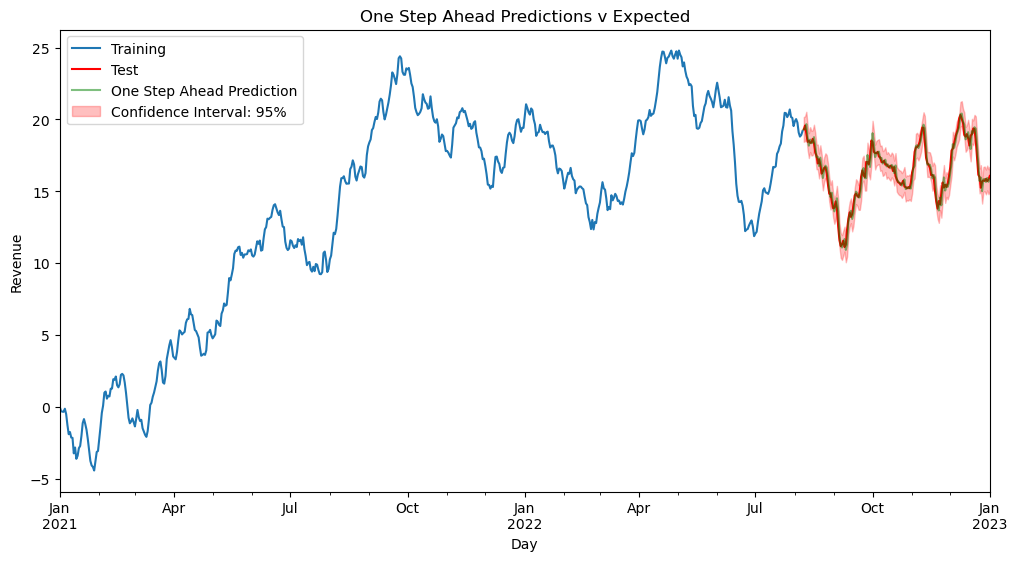

In [41]:
ax = train['Revenue'].plot(label = 'Training')
ax = test['Revenue'].plot(label = 'Test', color = 'r')

one_step_pred.predicted_mean.plot(ax = ax, label = 'One Step Ahead Prediction', alpha = .5, color = 'g')

ax.fill_between(one_step_pred_95.index,
                one_step_pred_95.iloc[:, 0],
                one_step_pred_95.iloc[:, 1], color = 'r', alpha = .25, label = "Confidence Interval: 95%")

plt.title('One Step Ahead Predictions v Expected')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc = 'upper left')
plt.show()

In [42]:
mod_pred = SARIMAX(train['Revenue'], order = (auto_model.order), enforce_stationarity = False,enforce_invertibility = False)
pred_mod = mod_pred.fit(disp = False)

print(pred_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -347.460
Date:                Sun, 25 Jun 2023   AIC                            700.920
Time:                        22:15:32   BIC                            714.009
Sample:                    01-01-2021   HQIC                           706.023
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3933      0.040      9.735      0.000       0.314       0.472
ma.L2          0.2213      0.040      5.475      0.000       0.142       0.300
sigma2         0.1940      0.012     15.718      0.0

In [43]:
pred = pred_mod.get_prediction(start = start, end = end)

ci_95 = pred.conf_int(alpha = .05)
ci_80 = pred.conf_int(alpha = .2)

RMSE = rmse(test['Revenue'], pred.predicted_mean)
MSE = mse(test['Revenue'], pred.predicted_mean)
MAE = mae(test['Revenue'], pred.predicted_mean)

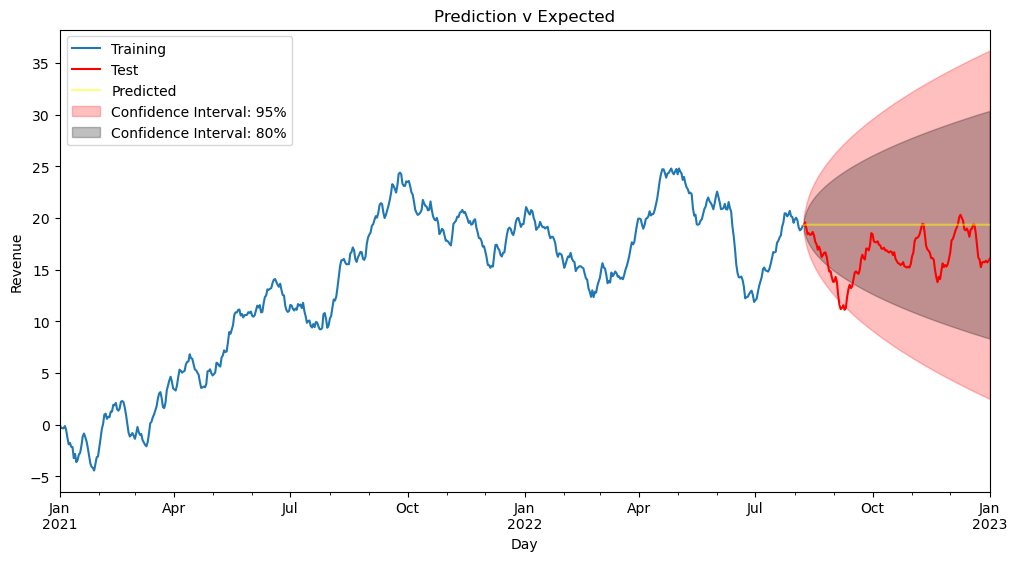

In [44]:
ax = train['Revenue'].plot(label = 'Training')
ax = test['Revenue'].plot(label = 'Test', color = 'r')

pred.predicted_mean.plot(ax = ax, label = 'Predicted', alpha = .5, color='yellow')

first_day_val = train.cumsum().loc[train.index[-1]][0]
pred_forecasted = pred_mod.get_forecast(steps = 147)
forecasted_mean = pred_forecasted.predicted_mean.cumsum() + first_day_val

ax.fill_between(ci_95.index,
                ci_95.iloc[:, 0],
                ci_95.iloc[:, 1], color = 'r', alpha = .25, label = "Confidence Interval: 95%")
ax.fill_between(ci_80.index,
                ci_80.iloc[:, 0],
                ci_80.iloc[:, 1], color = 'k', alpha = .25, label = "Confidence Interval: 80%")

plt.title('Prediction v Expected')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc = 'upper left')
plt.show()

In [45]:
forecast_model = SARIMAX(df['Revenue'], order = (auto_model.order), enforce_stationarity = False, enforce_invertibility = False)
forecast_model_fit = forecast_model.fit(disp = False)

forecast = forecast_model_fit.get_forecast(steps = 90)
pred_ci_95 = forecast.conf_int(.05)
pred_ci_80 = forecast.conf_int(alpha = 0.2)

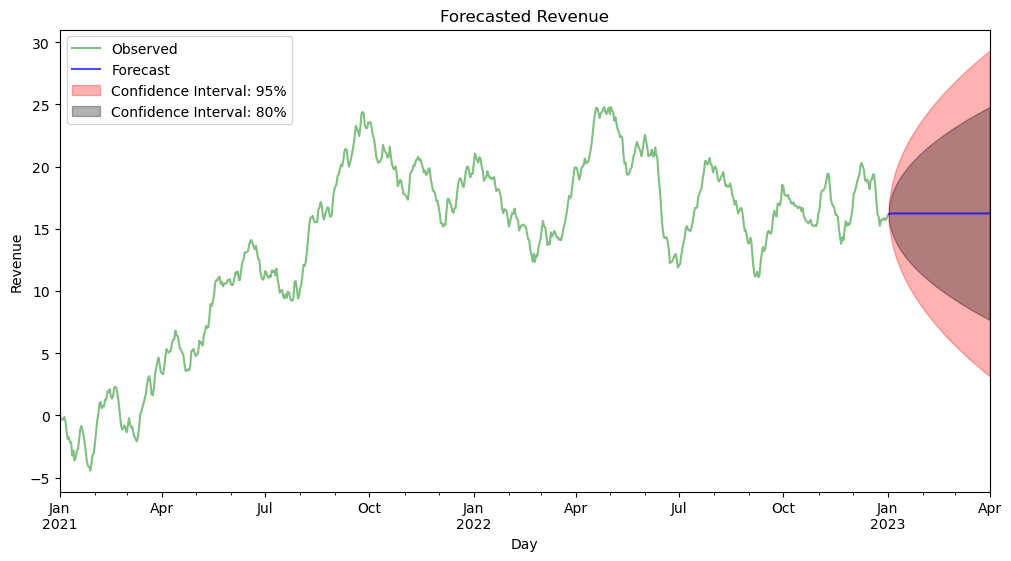

In [46]:
ax = df['Revenue'].plot(label = 'Observed', alpha = .5, color='g')

forecast.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .7, color='b')

ax.fill_between(pred_ci_95.index,
                pred_ci_95.iloc[:, 0],
                pred_ci_95.iloc[:, 1], color = 'r', alpha = .3, label = "Confidence Interval: 95%")

ax.fill_between(pred_ci_80.index,
                pred_ci_80.iloc[:, 0],
                pred_ci_80.iloc[:, 1], color = 'k', alpha = .3, label = "Confidence Interval: 80%")

plt.title('Forecasted Revenue')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc = 'upper left')
plt.show()

## Summary and Implications

### Selection of an ARIMA model

<p>The time-series was not stationary. A check was performed in step C3 to count how many times the series would need to be differenced to become stationary. The result was one order of differencing, which was confirmed by the later ACF and PACF checks. The result suggested that the best value of d would be 1.</p>
<p>An Auto-Arima was performed in step D2, which suggested the best model order was 0, 1, 2. The suggestion was based on the lowest AIC score and confirmed the earlier checks suggestion of d = 1.</p><br>
The Auto-ARIMA's suggested order was used in the final model.

### Prediction Interval of the Forecast

<p>The forecast used predication intervals at 95% and 80% as shown below.</p>

In [47]:
print('\n95% Interval:\n', pred_ci_95[:1])
print('\n80% Interval:\n', pred_ci_80[:1])


95% Interval:
             lower Revenue  upper Revenue
2023-01-02      15.329181      17.056087

80% Interval:
             lower Revenue  upper Revenue
2023-01-02      15.628052      16.757215


### Justification of the Forecast Length

<p>The chosen forecast length was 90 days.<br>
The business question asks: "Can the first two years of revenue data be used to forecast the next quarter's revenue?"<br>
Businesses operate in 90-day quarters, which is why a 90-day forecast was chosen.</p>

### Model Evaluation Procedure and Error Metric

<p>An Auto-ARIMA was performed to select the best model based on the lowest AIC Score.<br>
    The final model had an AIC Score of 700.920.</p>
<p>The error metrics are displayed below.</p>

In [48]:
print(' MSE: ' "%.3f" % MSE)
print(' MAE: ' "%.3f" % MAE) 
print('RMSE: ' "%.3f" % RMSE)

 MSE: 12.503
 MAE: 2.957
RMSE: 3.536


##  Visualization of the Final Model's Forecast Compared to the Test Set

In [49]:
pred_model = SARIMAX(train['Revenue'], order =(auto_model.order))
pred_model_fit = init_model.fit(disp = False)

start = len(train['Revenue'])
end = len(train['Revenue']) + len(test['Revenue'] - 1)

prediction = pred_model_fit.get_prediction(start = start, end = end)
prediction_ci_95 = prediction.conf_int(.05)
prediction_ci_80 = prediction.conf_int(alpha= 0.2)


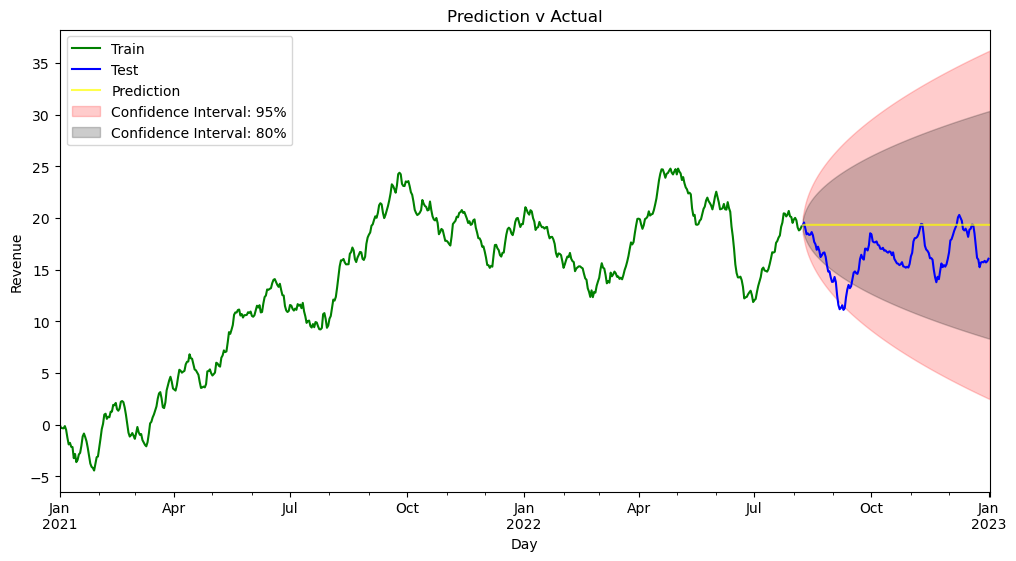

In [50]:
ax = train['Revenue'].plot(label = 'Train', color = 'g')
ax = test['Revenue'].plot(label = 'Test', color = 'b')

prediction.predicted_mean.plot(ax = ax, label = 'Prediction', alpha = .7, color = 'yellow')

ax.fill_between(prediction_ci_95.index,
                prediction_ci_95.iloc[:, 0],
                prediction_ci_95.iloc[:, 1], color='r', alpha=.2, label = 'Confidence Interval: 95%')

ax.fill_between(prediction_ci_80.index,
                prediction_ci_80.iloc[:, 0],
                prediction_ci_80.iloc[:, 1], color = 'k', alpha = .2, label = 'Confidence Interval: 80%')

plt.title('Prediction v Actual')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc='upper left')
plt.show()

### Recommended Course of Action
<p>The time series includes data from when the hospital first opened. The initial values are in the negative because it took time for the hospital to become profitable.
    The negative values skew the analysis, as evidenced by the chart titled <em>Prediction v Actual.</em><br>
The 95% confidence interval holds a wide range of values that do not properly represent the hospital's current revenue generation. The interval could be tightened up by excluding the initial negative values and replacing them with newer, more appropriate values.</p>
<p>I would suggest the organization use the analysis to predict the next quarter's results. However, I would encourage the organization to move the start date of the analysis up by one quarter, every quarter, to ensure the model includes the most up-to-date data.</p>
<p>Moving the start date of the time series forward as each quarter passes will eventually remove the initial negative values, increasing the accuracy over time.</p>

<strong>References:</strong><br>
<ul>
    <li>Dotis-Georgiou, Anais. (2019). <em>Autocorrelation in Time Series Data.</em>www.influxdata.com/blog/autocorrelation-in-time-series-data.</li>
    <li>Dr. Avishek Pal, & Dr. PKS Prakash. (2017). <em>Practical Time Series Analysis : Step by Step Guide Filled with Real World Practical Examples</em>. Packt Publishing.</li>
</ul>